In [1]:
#   This software component is licensed by ST under BSD-3-Clause license,
#   the "License"; You may not use this file except in compliance with the
#   License. You may obtain a copy of the License at:
#             https://opensource.org/licenses/BSD-3-Clause

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/STMicroelectronics/stm32ai/blob/master/AI_resources/HAR/Human_Activity_Recognition.ipynb)

# Human Activity Recognition

This notebook shows the process of creating a basic motion sensing activity classifier model, using Keras, for STM32 embedded applications.


## Import TensorFlow

Use TensorFlow 2.5.0 to be aligned with X-CUBE-AI v7.0.0.

In [1]:
import tensorflow as tf
print(tf.version.VERSION)

2.2.0


## Loading the dataset

The dataset is composed of 3-axis acceleration values stored in `.csv` text format. Each individual file corresponds to a capture characterised by it's containing folder name.

Download and extract the dataset:

In [3]:
!wget -nc https://github.com/STMicroelectronics/stm32ai/raw/master/AI_resources/HAR/dataset.zip

'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [4]:
!unzip -n dataset.zip

'unzip' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


Load the dataset into memory:

In [2]:
import glob
import numpy as np

# Load data into memory
labels = ['egg_kongzai', 'egg_zhongjian', 'egg_wentai','guanzi_zhongjian',
          'guanzi_wentai', 'shengnvguo_zhongjian', 'shengnvguo_wentai']
x_recordings = []
y_recordings = []
recordings_filenames = []
for i, label in enumerate(labels):
    filenames = glob.glob('dataset/' + label + '/*.csv')
    for filename in filenames:
        data = np.loadtxt(filename, delimiter=',')
        x_recordings.append(data)
        y_recordings.append(i)
        recordings_filenames.append(filename)
x_recordings=np.array(x_recordings)
x_recordings.shape
y_recordings = np.array(y_recordings)
#x_recordings = np.array(x_recordings).reshape(len(x_recordings), -1, 2)
#y_recordings = np.array(y_recordings)

#print(x_recordings.shape)
#print(y_recordings.shape)
#x_recordings

## Exploring the dataset
To verify that the dataset has been loaded correctly, let's display and plot a few captures at random.

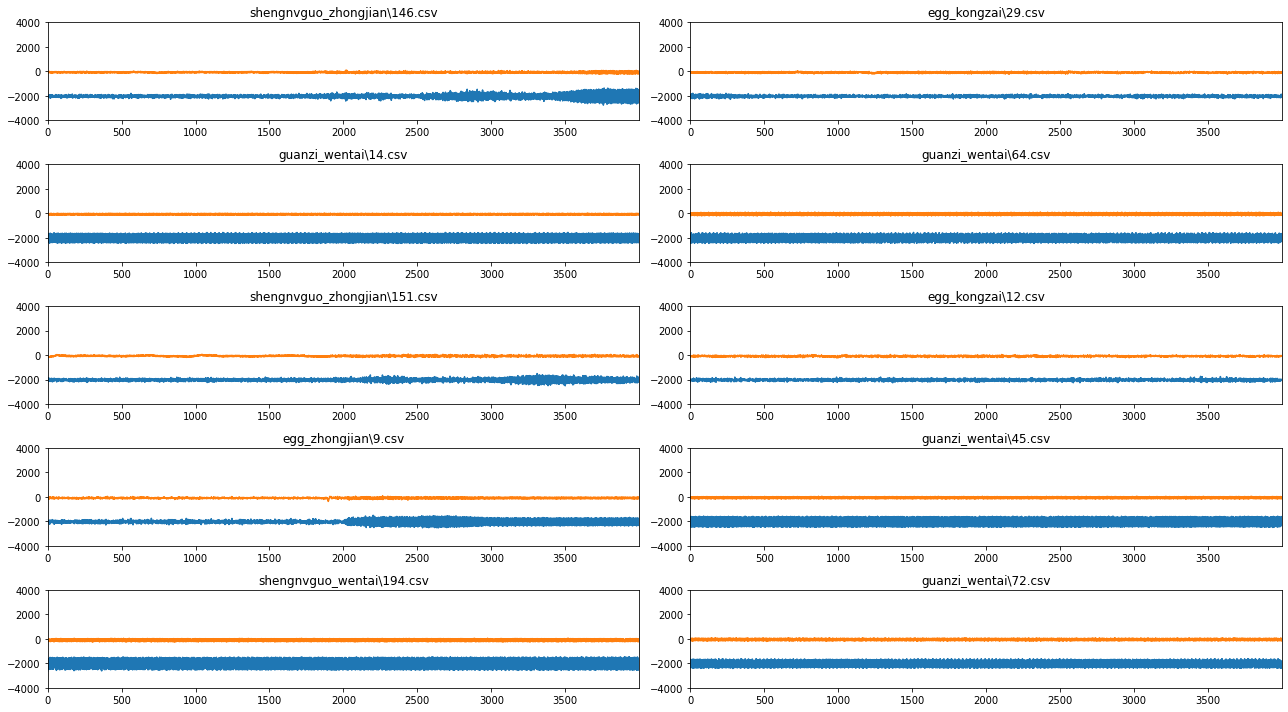

In [3]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Plot some captures
random.seed(10)
unique_rands = random.sample(range(len(x_recordings)), 10)
plt.figure(figsize=(18, 10))
for i, n in enumerate(unique_rands):
    plt.subplot(5, 2, i + 1)
    plt.margins(x=0, y=-0.25)
    plt.plot(x_recordings[n])
    plt.ylim(-4000, 4000)  # 4000 mg acc. range
    plt.title(recordings_filenames[n].split('/')[-1])
plt.tight_layout()
plt.show()

## Frame data

Each capture is framed into smaller windows. The window size will be the input dimension for the neural network. Optional overlapping can be added to further increase the number of points in our data for training and testing.

Here we are dividing the dataset into 1 second frames (26 samples at 26 Hz):

In [4]:
import numpy as np

def frame(x, frame_len, hop_len):
    '''Slice a 3D data array into (overlapping) frames.
    
    Example
    --------
    >>> x = np.array([[0, 1, 2],
                      [10, 11, 12],
                      [20, 21, 22],
                      [30, 31, 32],
                      [40, 41, 42],
                      [50, 51, 52],
                      [60, 61, 62]])
    >>> frames = x.frame(x, 3, 2)
    >>> x.shape
    (7, 3)
    >>> frames.shape
    (3, 3, 3)
    '''

    assert(x.shape == (len(x), 2))
    assert(x.shape[0] >= frame_len)
    assert(hop_len >= 1)

    n_frames = 1 + (x.shape[0] - frame_len) // hop_len
    shape = (n_frames, frame_len, x.shape[1])
    strides = ((hop_len * x.strides[0],) + x.strides)
    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

x_frames = []
y_frames = []
for i in range(x_recordings.shape[0]):
    # frames = frame(x_recordings[i], 26, 26) # no overlap
    frames = frame(x_recordings[i], 4000, 2000) # 50% overlap
    x_frames.append(frames)
    y_frames.append(np.full(frames.shape[0], y_recordings[i]))

print(np.array(x_frames).shape)
x_frames = np.concatenate(x_frames)
y_frames = np.concatenate(y_frames)
print(x_frames.shape)

# Each output label is an integer between 0 and 2:
print(y_frames.shape)
print(labels)

(921, 1, 4000, 2)
(921, 4000, 2)
(921,)
['egg_kongzai', 'egg_zhongjian', 'egg_wentai', 'guanzi_zhongjian', 'guanzi_wentai', 'shengnvguo_zhongjian', 'shengnvguo_wentai']


## Preprocessing the dataset

To improve the model's performance, it is recommended to perform some kind of pre-processing on the input data before feeding them to the neural network model. Data pre-processing can include filtering, gravity rotation and/or suppression as it is done in [FP-AI-SENSING1]. In this example, a simple data scaling will suffice.

Data scaling can be achieved by normalizing or standardizing input data. In this example, data is normalized into floating point values between `-1.0` and `1.0` by dividing them by the sensor's full range (`4000 mg`).

[FP-AI-SENSING1]:https://www.st.com/en/embedded-software/fp-ai-sensing1.html

In [5]:
# Normalize input data between [-1;1]
x_frames_normed = x_frames / 4000

### Preparing the dataset (train, test, split)
The dataset is split into a _train_ and _test_ set. The data is first shuffled and then split with 25% reserved for model evaluation and testing purposes.

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x_frames_normed, y_frames, test_size=0.25)

print("Trainning samples:", x_train.shape)
print("Testing samples:", x_test.shape)
print("Trainning samples:", y_train.shape)
print("Testing samples:", y_test.shape)

Trainning samples: (690, 4000, 2)
Testing samples: (231, 4000, 2)
Trainning samples: (690,)
Testing samples: (231,)


## Creating the model

Let's create a classifier model using Keras.

Build the tf.keras.Sequential model by stacking layers. Choose an optimizer and loss function for training:

In [7]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow as tf


class SqueezeNet(keras.Model):

    def __init__(self):
        super(SqueezeNet, self).__init__()
        self.conv1 = layers.Conv1D(filters=32, kernel_size=3, strides=2, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.act1 = Mish()
        self.pool1 = layers.MaxPooling1D(pool_size=3,strides=2, padding='same')
        self.fire_block2 = FireBlock(16, 16, 16)
        #self.fire_block3 = FireBlock(16, 16, 32)
        self.fire_block4 = FireBlock(16, 16, 16)
        self.pool4 = layers.MaxPooling1D(pool_size=3,strides=2, padding='same')
        
        
        self.fire_block5 = FireBlock(8, 8 , 8)
        '''
        self.fire_block6 = FireBlock(48, 192, 192)
        self.fire_block7 = FireBlock(48, 192, 192)
        self.fire_block8 = FireBlock(64, 256, 256)
        '''
        self.pool8 = layers.MaxPooling1D(pool_size=3,strides=2, padding='same')
        #self.fire_block9 = FireBlock(64, 64, 128)

    def __call__(self, inputs=None):
        if not inputs:
            #inputs = keras.Input(shape=(224, 224, 3))
            inputs = keras.Input(shape=(4000, 2))

        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.pool1(x)  # C2
        x = self.fire_block2(x)
        #x = self.fire_block3(x)
        x = self.fire_block4(x)
        
        x = self.pool4(x)  # C3
        
        x = self.fire_block5(x)
        '''
        x = self.fire_block6(x)
        x = self.fire_block7(x)
        x = self.fire_block8(x)
        '''
        x = self.pool8(x)  # C4
        #x = self.fire_block9(x)
        #x = tf.keras.layers.Dropout(0.4)(x)

        x = keras.layers.Flatten()(x)
        
        #x = keras.layers.Dense(10, activation='relu')(x)
        x = keras.layers.Dense(7, activation='softmax')(x)

        squeezenet = keras.Model(inputs, x)
        return squeezenet


class FireBlock(layers.Layer):

    def __init__(self, filter1, filter2, filter3):
        super(FireBlock, self).__init__()
        self.conv1 = layers.Conv1D(filters=filter1, kernel_size=1, padding='same', use_bias=False)
        self.conv2 = layers.Conv1D(filters=filter2, kernel_size=1, padding='same', use_bias=False)
        self.conv3 = layers.Conv1D(filters=filter3, kernel_size=3, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()

    def __call__(self, inputs):
        squeeze_x = self.conv1(inputs)
        squeeze_x = self.bn1(squeeze_x)
        squeeze_x = Mish()(squeeze_x)
        expand_x1 = self.conv2(squeeze_x)
        expand_x1 = self.bn2(expand_x1)
        expand_x1 = Mish()(expand_x1)
        expand_x3 = self.conv3(squeeze_x)
        expand_x3 = self.bn3(expand_x3)
        expand_x3 = Mish()(expand_x3)

        merge_x = layers.Concatenate()([expand_x1, expand_x3])

        return merge_x


class Mish(layers.Layer):

    def __init__(self):
        super(Mish, self).__init__()

    def __call__(self, inputs):
        return tf.multiply(inputs, tf.tanh(tf.nn.softplus(inputs)))


if __name__ == '__main__':
    squeeze_net = SqueezeNet()
    model = squeeze_net()
    model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4000, 2)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2000, 32)     192         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2000, 32)     128         conv1d[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Softplus (TensorFlo [(None, 2000, 32)]   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:


model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(x_train, y_train, epochs=130)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print("Test loss:", test_loss)
print("Test acc:", test_acc)
'''
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_train = model.fit(x=x_train,y=y_train,validation_split=0.2,epochs=10,batch_size=30,verbose=1)
'''



Epoch 1/130
22/22 [==============================] - 0s 22ms/step - loss: 1.0473 - accuracy: 0.6188
Epoch 2/130
22/22 [==============================] - 0s 11ms/step - loss: 0.2244 - accuracy: 0.9348
Epoch 3/130
22/22 [==============================] - 0s 11ms/step - loss: 0.1070 - accuracy: 0.9638
Epoch 4/130
22/22 [==============================] - 0s 11ms/step - loss: 0.0870 - accuracy: 0.9754
Epoch 5/130
22/22 [==============================] - 0s 11ms/step - loss: 0.0316 - accuracy: 0.9957
Epoch 6/130
22/22 [==============================] - 0s 11ms/step - loss: 0.0323 - accuracy: 0.9942
Epoch 7/130
22/22 [==============================] - 0s 11ms/step - loss: 0.0141 - accuracy: 0.9986
Epoch 8/130
22/22 [==============================] - 0s 11ms/step - loss: 0.0136 - accuracy: 0.9986
Epoch 9/130
22/22 [==============================] - 0s 11ms/step - loss: 0.0151 - accuracy: 0.9957
Epoch 10/130
22/22 [==============================] - 0s 11ms/step - loss: 0.0203 - accuracy: 0.9957

"\nmodel.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])\nmodel_train = model.fit(x=x_train,y=y_train,validation_split=0.2,epochs=10,batch_size=30,verbose=1)\n"

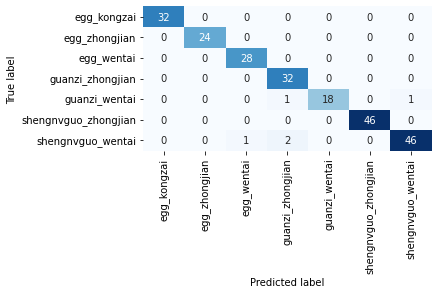

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(confusion_matrix,
            annot=True,
            xticklabels=labels,
            yticklabels=labels,
            cmap=plt.cm.Blues,
            fmt='d', cbar=False)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [10]:
# Save the model into an HDF5 file ‘model.h5’
model.save('SqueezeNet.h5')

In [1]:
import tensorflow as tf

model = tf.keras.models.load_model('SqueezeNet.h5')


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('SqueezeNet.tflite', 'wb') as f:
  f.write(tflite_model)